In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('seaborn')

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
columns = ['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value',
'ocean_proximity']

## Data Preparation

In [4]:
df = df[columns]
df = df.fillna(0)

In [5]:
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df['rooms_per_household'] = df['total_rooms']/df['households']
df['bedrooms_per_room'] = df['total_bedrooms']/df['total_rooms']
df['population_per_household'] = df['population']/df['households']

In [7]:
numeric = df.select_dtypes('float').columns.tolist()
categorical = df.select_dtypes('object').columns.tolist()

In [8]:
numeric

['latitude',
 'longitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household']

In [9]:
categorical

['ocean_proximity']

## Q1
What is the most frequent observation (mode) for the column ocean_proximity?

In [10]:
df['ocean_proximity'].mode()

0    <1H OCEAN
Name: ocean_proximity, dtype: object

## Q2

- Create the correlation matrix for the numerical features of your train dataset.
  - In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.
- What are the two features that have the biggest correlation in this dataset?

In [11]:
numeric_df = df[numeric].copy()
corr = numeric_df.corr()

<AxesSubplot:>

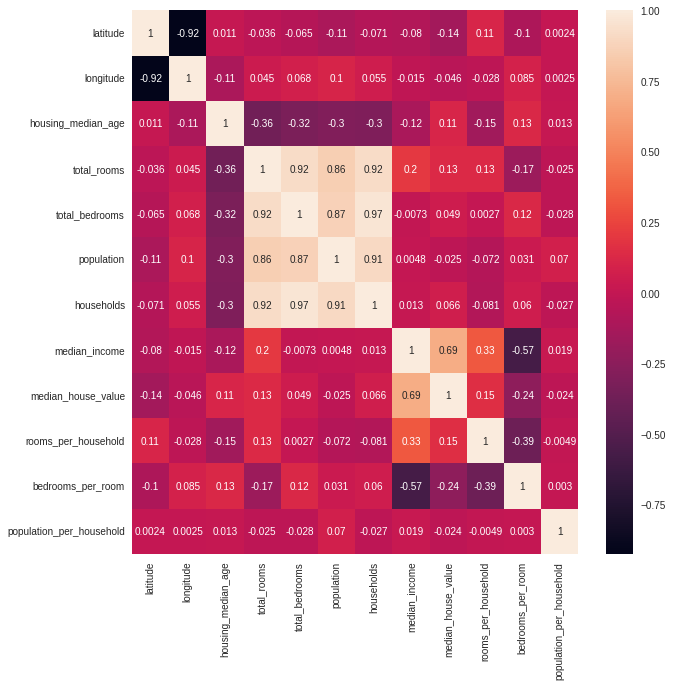

In [12]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,annot=True,ax=ax)

In [13]:
sorted = corr.unstack().abs()[corr.unstack().abs() < 1].sort_values(ascending=False)
vals = sorted.index[0]
print(f"The variables with the highest correlations are {vals}")

The variables with the highest correlations are ('households', 'total_bedrooms')


### Make `median_house_value` binary

In [14]:
avg_house_val = df.median_house_value.mean()
print(f"The average house value is {avg_house_val} ")
values = np.where(df.median_house_value > avg_house_val,1,0)
df['above_average'] = values

The average house value is 206855.81690891474 


In [15]:
df[['median_house_value','above_average']]

,median_house_value,above_average
0,452600.0,1
1,358500.0,1
2,352100.0,1
3,341300.0,1
4,342200.0,1
...,...,...
20635,78100.0,0
20636,77100.0,0
20637,92300.0,0
20638,84700.0,0


### Split the data

- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value (median_house_value) is not in your dataframe.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
df_full_train, df_test = train_test_split(df,test_size=0.2,random_state=42)
print(f"full train has {len(df_full_train)} samples which is 80% of the dataset, test dataset has {len(df_test)} samples which is 20%")

full train has 16512 samples which is 80% of the dataset, test dataset has 4128 samples which is 20%


In [18]:
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=42)
print(f"train has {len(df_train)} samples which is 60% of the dataset, val dataset has {len(df_val)} samples which is 20%")

train has 12384 samples which is 60% of the dataset, val dataset has 4128 samples which is 20%


In [19]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [20]:
df_train.columns

Index(['latitude', 'longitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'rooms_per_household',
       'bedrooms_per_room', 'population_per_household', 'above_average'],
      dtype='object')

In [21]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

In [22]:
y_train_num = df_train.median_house_value.values
y_val_num = df_val.median_house_value.values
y_test_num = df_test.median_house_value.values

In [23]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

## Question 3
- Calculate the mutual information score with the (binarized) price for the categorical variable that we have. Use the training set only.
- What is the value of mutual information?
- Round it to 2 decimal digits using round(score, 2)

In [24]:
from sklearn.metrics import mutual_info_score

In [25]:
mi = mutual_info_score(df_train[categorical].values.reshape(-1,),y_train)
round(mi,2)

0.1

## Q4
- Now let's train a logistic regression
- Remember that we have one categorical variable ocean_proximity in the data. Include it using one-hot encoding.


In [26]:
from sklearn.feature_extraction import DictVectorizer

In [27]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

In [28]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [29]:
dv.get_feature_names_out()

array(['bedrooms_per_room', 'households', 'housing_median_age',
       'latitude', 'longitude', 'median_income',
       'ocean_proximity=<1H OCEAN', 'ocean_proximity=INLAND',
       'ocean_proximity=ISLAND', 'ocean_proximity=NEAR BAY',
       'ocean_proximity=NEAR OCEAN', 'population',
       'population_per_household', 'rooms_per_household',
       'total_bedrooms', 'total_rooms'], dtype=object)

- Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
- Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)

model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [32]:
y_val_pred = model.predict(X_val)

In [33]:
original_accuracy = (y_val==y_val_pred).mean().round(2)
print(f"The accuracy on the validation is:{(y_val==y_val_pred).mean().round(2)}")

The accuracy on the validation is:0.84


## Q5

- Let's find the least useful feature using the feature elimination technique.
- Train a model with all these features (using the same parameters as in Q4).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

In [34]:
features = df_train.columns.tolist()
features

['latitude',
 'longitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household']

In [35]:
new_features = features.copy()
new_features.remove('total_rooms')
len(new_features),len(features)

(11, 12)

In [36]:
scores = {}
for i,feat in enumerate(features):

    new_feats = features.copy()
    new_feats.remove(feat)

    new_train_dicts = df_train[new_feats].to_dict(orient='records')
    new_val_dicts = df_val[new_feats].to_dict(orient='records')
    dv_new = DictVectorizer(sparse=False)
    new_X_train = dv_new.fit_transform(new_train_dicts)
    new_X_val = dv_new.transform(new_val_dicts)
    
    new_model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)

    new_model.fit(new_X_train,y_train)

    y_val_pred = new_model.predict(new_X_val)
    accuracy = (y_val==y_val_pred).mean().round(2)
    scores.update({feat:(original_accuracy-accuracy)})


In [37]:
scores

{'latitude': 0.010000000000000009,
 'longitude': 0.010000000000000009,
 'housing_median_age': 0.010000000000000009,
 'total_rooms': 0.0,
 'total_bedrooms': 0.0,
 'population': 0.010000000000000009,
 'households': 0.010000000000000009,
 'median_income': 0.04999999999999993,
 'ocean_proximity': 0.020000000000000018,
 'rooms_per_household': 0.0,
 'bedrooms_per_room': 0.0,
 'population_per_household': 0.0}

In [38]:
min(scores,key=scores.get)

'total_rooms'

## Q6

- For this question, we'll see how to use a linear regression model from Scikit-Learn
- We'll need to use the original column 'median_house_value'. Apply the logarithmic transformation to this column.
- Fit the Ridge regression model (model = Ridge(alpha=a, solver="sag", random_state=42)) on the training data.
- This model has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10]
- Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

In [39]:
from sklearn.linear_model import Ridge

In [40]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [41]:
y_train_num_log = np.log1p(y_train_num)
y_val_num_log = np.log1p(y_val_num)

In [42]:
def rmse(y_preds,y):

    mse = np.sum((y_preds-y)**2)/len(y_preds)
    rmse = np.sqrt(mse)
    return rmse

In [43]:
alphas = [0, 0.01, 0.1, 1, 10]
scores = {}
for i,a in enumerate(alphas):

    ridge_model = Ridge(alpha=a, solver="sag", random_state=42)

    ridge_model.fit(X_train,y_train_num_log)
    y_val_pred = ridge_model.predict(X_val)
    score = rmse(y_preds=y_val_pred,y=y_val_num_log)
    scores.update({str(a):score})

In [44]:
scores

{'0': 0.5240635707015139,
 '0.01': 0.524063570718629,
 '0.1': 0.5240635708812071,
 '1': 0.5240635725155535,
 '10': 0.5240635888333284}

In [45]:
min(scores,key=scores.get)

'0'